# Chapter 09 시계열을 위한 머신러닝

## 9.1 사계열 분류

### 9.1.1 특징의 선택과 생성

### 필요한 데이터셋 다운로드
    * EEG 데이터셋
      각 시계열의 길이가 같음
      1. 눈을 뜨거나 감은(두 개의 별도 범주) 건강한 사람에 대한 EEG 기록
      2. 발작이 발생하지 않은 간질 환자의 발작과는 관련 없는 두뇌의 두 부위에 대한 EEG 기록 (두개의 별도 범주)
      3. 발작 중 뇌파 내 EEG 기록 (단일 범주)


In [2]:
!pip install cesium

     |████████████████████████████████| 220 kB 5.4 MB/s 
     |████████████████████████████████| 554 kB 45.4 MB/s 
  Created wheel for gatspy: filename=gatspy-0.3-py3-none-any.whl size=43819 sha256=e642f346c03cad3fe4d90e19eff6dcd9cb3c89417ca63828d3847caf6b7410ce
  Stored in directory: /root/.cache/pip/wheels/1f/c1/4c/8de278f816259b4f67e2356c0bda260a593375661e400bf31f
Successfully built gatspy


In [4]:
from cesium import datasets
eeg = datasets.fetch_andrzejak()

데이터 일부 샘플을 통해 분류를 위한 아이디어 파악

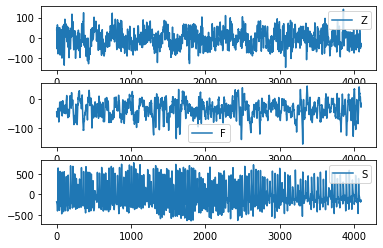

In [5]:
import matplotlib.pyplot as plt
plt.subplot(3, 1, 1)
plt.plot(eeg["measurements"][0])
plt.legend(eeg['classes'][0])
plt.subplot(3, 1, 2)
plt.plot(eeg["measurements"][300])
plt.legend(eeg['classes'][300])
plt.subplot(3, 1, 3)
plt.plot(eeg["measurements"][450])
plt.legend(eeg['classes'][450])

cesium을 통한 특징의 생성 밥법

In [8]:
from cesium.featurize import featurize_time_series as ft

features_to_use = ["amplitude",
                   "percent_beyond_1_std",
                   "percent_close_to_median",
                   "skew",
                   "max_slope"]

fset_cesium = ft(times = eeg["times"],
                 values = eeg["measurements"],
                 errors = None,
                 features_to_use = features_to_use,
                 scheduler = None)

In [10]:
fset_cesium.head()

feature,amplitude,percent_beyond_1_std,percent_close_to_median,skew,max_slope
channel,0,0,0,0,0
0,143.5,0.327313,0.505004,0.032805,11107.796610
1,211.5,0.290212,0.640469,-0.092715,20653.559322
2,165.0,0.302660,0.515987,-0.004100,13537.627119
3,171.5,0.300952,0.541128,0.063678,17008.813559
4,170.0,0.305101,0.566268,0.142753,13016.949153


오류 검사 by percent_beyond_1_std

In [11]:
import numpy as np

np.std(eeg["measurements"][0])

40.41100040099819

In [12]:
np.mean(eeg["measurements"][0])

-4.1320478398828415

In [13]:
sample_ts = eeg["measurements"][0]
sz = len(sample_ts)
ll = -4.13 - 40.4
ul = -4.13 + 40.4
quals = [i for i in range(sz) if sample_ts[i] < ll or sample_ts[i] >ul]

len(quals) / sz # 위에서의 값과 일치

0.3273126678057115

### 9.1.2 결정 트리 기법

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(fset_cesium.values, eeg["classes"], random_state=21)

랜덤포레스트

In [18]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators = 10,
                                max_depth    =  3,
                                random_state = 21)

rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10, random_state=21)

In [19]:
rf_clf.score(X_test, y_test)

0.616

그레디언트 부스팅 트리

In [20]:
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(n_estimators  = 10,
                            max_depth     =  3,
                            random_state  = 21)

xgb_clf.fit(X_train, y_train)

XGBClassifier(n_estimators=10, objective='multi:softprob', random_state=21)

In [21]:
xgb_clf.score(X_test, y_test)

0.648

각 모델의 학습시간 추정

In [30]:
import time

start = time.time()
xgb_clf.fit(X_train, y_train)
end = time.time()
(end - start) * 100

2.172207832336426

In [31]:
start = time.time()
rf_clf.fit(X_train, y_train)
end = time.time()
(end - start) * 100

3.4586429595947266